# Recommendation model 

* Write summary here *

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# Read csv file
def read_data(path, includeDates=False):
    
    if includeDates:
        data = pd.read_csv(path) 
                          #parse_dates=['timestamp'])
    else:
        data = pd.read_csv(path)
    return data

Reading the csv files and checking out the data

In [4]:
rating_data = read_data('data/ratings.csv', True)
movie_data = read_data('data/movies.csv')
tags_data = read_data('data/tags.csv')
links_data = read_data('data/links.csv')
display(rating_data.head(5))
display(movie_data.head(5))
display(tags_data.head(5))
display(links_data.head(5))

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Checking out the raiting data and movie csv further

In [5]:
# Checking out data types
print(rating_data.dtypes)
print()
print(movie_data.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

movieId     int64
title      object
genres     object
dtype: object


In [6]:
# Checking out number of instances
print(rating_data.shape)
print(movie_data.shape)

(7570586, 4)
(58098, 3)


In [7]:
# Checking out number of unique movies
# Output interpretation: Around 20k of the movies have not been reviewed. 
print(len(rating_data['movieId'].unique()))
print(len(movie_data['movieId'].unique()))

38230
58098


In [8]:
# Checking out number of unique users who have rated
len(rating_data['userId'].unique())

77932

In [9]:
display(rating_data.head(5))
#rating_data.drop(columns=['timestamp'], inplace=True)
display(movie_data.head(5))
#movie_data.drop(columns=['genres'], inplace=True)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
# Checking rating counts per movie
sum_ratings_per_movie = rating_data['movieId'].value_counts()
print(len(sum_ratings_per_movie))
ids_to_keep = sum_ratings_per_movie[sum_ratings_per_movie >= 20].index
print(len(ids_to_keep))
rating_data_filtered = rating_data.loc[rating_data['movieId'].isin(ids_to_keep)]

# Get the movies
unique_movies = rating_data_filtered.drop_duplicates(subset=['movieId'], keep='last')
display(unique_movies)
print("Length of new dataset: ", len(unique_movies))

38230
11666


,userId,movieId,rating,timestamp
5681826,58569,61073,2.5,1285169940
5893507,60651,8133,3.5,1201821423
5971581,61363,136305,1.0,1470925717
5999583,61625,64236,3.5,1295367183
6039042,61993,104631,2.5,1449400164
...,...,...,...,...
7570581,77931,1517,4.0,947773686
7570582,77931,2639,3.0,947773686
7570583,77931,3095,5.0,947773606
7570584,77932,94,5.0,1469460226


Length of new dataset:  11666


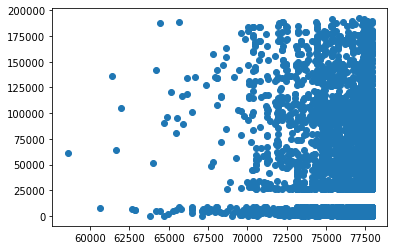

In [11]:
# Plot all movies with more than 19 ratings and the number of ratings for each movie

import matplotlib.pyplot as plt

plt.scatter(unique_movies['userId'], unique_movies['movieId'])

In [12]:
# Reshaping the dataset so that we can use KNN 
# To a sparse matrix (m x n) where m = movies and n = users

from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = unique_movies.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)
                            
hashmap = {
    movie: i for i, movie in
    enumerate(list(movie_data.set_index('movieId').loc[df_movie_features.index].title)) # noqa
}

In [13]:
df_movie_features.head(5)

userId,58569,60651,61363,61625,61993,62634,62861,63810,64000,64161,...,77923,77924,77925,77926,77927,77928,77929,77930,77931,77932
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [17]:
import os
import time
import gc
from fuzzywuzzy import fuzz

class KnnRecommender:
    """
    This is an item-based collaborative filtering recommender with
    KNN implmented by sklearn
    """
    def __init__(self, data, hashmap):
        self.data = data
        self.hashmap = hashmap
        self.movie_rating_thres = 0
        self.user_rating_thres = 0
        self.model = NearestNeighbors()
        
    def set_model_params(self, n_neighbors, algorithm, metric, n_jobs=None):
        """
        set model params for sklearn.neighbors.NearestNeighbors
        Parameters
        ----------
        n_neighbors: int, optional (default = 5)
        algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, optional
        metric: string or callable, default 'minkowski', or one of
            ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
        n_jobs: int or None, optional (default=None)
        """
        if n_jobs and (n_jobs > 1 or n_jobs == -1):
            os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'
        self.model.set_params(**{
            'n_neighbors': n_neighbors,
            'algorithm': algorithm,
            'metric': metric,
            'n_jobs': n_jobs})
        
    def _fuzzy_matching(self, hashmap, fav_movie):
        """
        return the closest match via fuzzy ratio.
        If no match found, return None
        Parameters
        ----------
        hashmap: dict, map movie title name to index of the movie in data
        fav_movie: str, name of user input movie
        Return
        ------
        index of the closest match
        """
        match_tuple = []
        # get match
        for title, idx in hashmap.items():
            ratio = fuzz.ratio(title.lower(), fav_movie.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print('Oops! No match is found')
        else:
            print('Found possible matches in our database: '
                  '{0}\n'.format([x[0] for x in match_tuple]))
            return match_tuple[0][1]
        
    def _inference(self, model, data, hashmap,
                   fav_movie, n_recommendations):
        """
        return top n similar movie recommendations based on user's input movie
        Parameters
        ----------
        model: sklearn model, knn model
        data: movie-user matrix
        hashmap: dict, map movie title name to index of the movie in data
        fav_movie: str, name of user input movie
        n_recommendations: int, top n recommendations
        Return
        ------
        list of top n similar movie recommendations
        """
        # fit
        model.fit(data)
        # get input movie index
        print('You have input movie:', fav_movie)
        idx = self._fuzzy_matching(hashmap, fav_movie)
        # inference
        print('Recommendation system start to make inference')
        print('......\n')
        t0 = time.time()
        distances, indices = model.kneighbors(
            data[idx],
            n_neighbors=n_recommendations+1)
        # get list of raw idx of recommendations
        raw_recommends = \
            sorted(
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                ),
                key=lambda x: x[1]
            )[:0:-1]
        print('It took my system {:.2f}s to make inference \n\
              '.format(time.time() - t0))
        # return recommendation (movieId, distance)
        return raw_recommends

        
    def make_recommendations(self, fav_movie, n_recommendations):
        """
        make top n movie recommendations
        Parameters
        ----------
        fav_movie: str, name of user input movie
        n_recommendations: int, top n recommendations
        """
        # get data
       # movie_user_mat_sparse, hashmap = self._prep_data()
        # get recommendations
        raw_recommends = self._inference(
            self.model, self.data, self.hashmap,
            fav_movie, n_recommendations)
        # print results
        reverse_hashmap = {v: k for k, v in self.hashmap.items()}
        print('Recommendations for {}:'.format(fav_movie))
        for i, (idx, dist) in enumerate(raw_recommends):
            print('{0}: {1}, with distance '
                  'of {2}'.format(i+1, reverse_hashmap[idx], dist))

ModuleNotFoundError: No module named 'fuzzywuzzy'

In [ ]:
if __name__ == '__main__':
    # get args

    recommender = KnnRecommender(mat_movie_features, hashmap)
    # set params
   # recommender.set_filter_params(50, 50)
    recommender.set_model_params(20, 'brute', 'cosine', -1)
    # make recommendations
    recommender.make_recommendations('Iron Man', 10)